## 필요한 모듈 임포트

In [1]:
import sys
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt


## Python 및 Tensorflow 버전 확인

In [2]:
print(f'Python Version: {sys.version}')
print(f'Tensorflow Version: {tf.__version__}')


Python Version: 3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]
Tensorflow Version: 2.9.1


## cifar10 이미지 로딩

In [3]:
# disable SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Training data:")
print("    Number of examples: ", X_train.shape[0])
print("    Number of channels:", X_train.shape[3])
print("    Image size:", X_train.shape[1], X_train.shape[2])
print()
print("Test data:")
print("    Number of examples:", X_test.shape[0])
print("    Number of channels:", X_test.shape[3])
print("    Image size:", X_test.shape[1], X_test.shape[2])
print()
print(X_train.shape, X_train.dtype)


Training data:
    Number of examples:  50000
    Number of channels: 3
    Image size: 32 32

Test data:
    Number of examples: 10000
    Number of channels: 3
    Image size: 32 32

(50000, 32, 32, 3) uint8


## 이미지 시각화

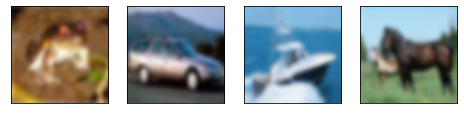

In [4]:
plt.figure(figsize=(8, 2))
plt.subplot(141)
plt.imshow(X_train[0], interpolation="bicubic")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.subplot(142)
plt.imshow(X_train[4], interpolation="bicubic")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.subplot(143)
plt.imshow(X_train[8], interpolation="bicubic")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.subplot(144)
plt.imshow(X_train[12], interpolation="bicubic")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()


## 이미지 정규화 ( 스케일링 )

In [5]:
print("mean before normalization:", np.mean(X_train))
print("std before normalization:", np.std(X_train))

mean = [0, 0, 0]
std = [0, 0, 0]
newX_train = np.ones(X_train.shape)
newX_test = np.ones(X_test.shape)
for i in range(3):
    mean[i] = np.mean(X_train[:, :, :, i])
    std[i] = np.std(X_train[:, :, :, i])

for i in range(3):
    newX_train[:, :, :, i] = X_train[:, :, :, i] - mean[i]
    newX_train[:, :, :, i] = newX_train[:, :, :, i] / std[i]
    newX_test[:, :, :, i] = X_test[:, :, :, i] - mean[i]
    newX_test[:, :, :, i] = newX_test[:, :, :, i] / std[i]


X_train = newX_train
X_test = newX_test

print("mean after normalization:", np.mean(X_train))
print("std after normalization:", np.std(X_train))
print(X_train.max())


mean before normalization: 120.70756512369792
std before normalization: 64.1500758911213
mean after normalization: 4.91799193961621e-17
std after normalization: 0.9999999999999996
2.126789409516928


## 모델 구현 및 훈련

### MyConv2D 구현

`tf.Module`을 상속하여 `tf.keras.layers.Conv2D` 와 유사하게 동작하는 `MyConv2D`를 구현한다.

In [6]:
class MyConv2D(tf.Module):
    def __init__(self, num_filters, kernel_size,
                 name=None, padding='SAME', strides=1, activation=None, input_shape=None):
        super().__init__(name=name)

        assert num_filters >= 1
        self._num_filters = num_filters

        kernel_size = np.array(kernel_size, dtype=np.uint32)
        if kernel_size.ndim == 0:
            kernel_size = np.array([kernel_size, kernel_size])
        else:
            kernel_size = kernel_size.flatten()

            if len(kernel_size) == 1:
                kernel_size = np.array([kernel_size[0], kernel_size[0]])
            else:
                kernel_size = np.array([kernel_size[0], kernel_size[1]])
        self._kernel_size = kernel_size

        self._weights = None
        self._bias = None

        if activation is None:
            self._activation = lambda x: x
        elif activation.upper() == 'RELU':
            self._activation = tf.nn.relu
        else:
            raise NotImplementedError(
                f'Activation {activation} not implemented!')

        self._is_built = False

        strides = np.array(strides, dtype=np.uint32)
        if strides.ndim == 0:
            strides = np.array([strides, strides])
        else:
            strides = strides.flatten()

            if len(strides) == 1:
                strides = np.array([strides[0], strides[0]])
            else:
                strides = np.array([strides[0], strides[1]])
        self._strides = strides
        self._padding = padding.upper()

        self._output_shape = None

        if input_shape is not None:
            self._build(input_shape)

    def _build(self, input_shape):
        input_shape = np.array(input_shape)
        assert input_shape.ndim == 1 and len(input_shape) == 3
        self._input_shape = input_shape

        input_rows, input_cols, input_channels = input_shape

        pad_size = [0, 0]
        if self._padding == 'SAME':
            pad_size = self._kernel_size - 1
        else:
            assert self._padding == 'VALID'

        output_rows = (
            input_rows - self._kernel_size[0] + pad_size[0]) // self._strides[0] + 1
        output_cols = (
            input_cols - self._kernel_size[1] + pad_size[1]) // self._strides[1] + 1
        self._output_shape = (output_rows, output_cols, self._num_filters)

        stddev = np.sqrt(2 / (np.prod(input_shape)))
        weight_shape = \
            (self._kernel_size[0], self._kernel_size[1],
             input_channels, self._num_filters)
        self._weights = tf.Variable(np.random.normal(0, stddev,
                                                     size=weight_shape), dtype=tf.float32)
        self._bias = tf.Variable(
            np.zeros(self._num_filters), dtype=tf.float32, name='bias')

        self._is_built = True

    def __call__(self, input):
        if not self._is_built:
            self._build(input.shape[1:])

        assert np.all(self._input_shape == input.shape[1:])

        if input.dtype != tf.float32:
            input = tf.cast(input, dtype=tf.float32)
        out = tf.nn.conv2d(input, self._weights, self._strides, self._padding) + \
            self._bias

        assert out.shape[1:] == self.output_shape

        return self._activation(out)

    @property
    def output_shape(self):
        return self._output_shape


`MyConv2D`가 제대로 구현되었는지 간단히 확인해본다.

In [7]:
conv2d = MyConv2D(64, (3, 3), padding='SAME', input_shape=(32, 32, 3))
assert conv2d.output_shape == (32, 32, 64)

conv2d = MyConv2D(32, (3, 3), padding='VALID', input_shape=(32, 32, 3))
assert conv2d.output_shape == (30, 30, 32)
out = conv2d(np.random.normal(size=(1, 32, 32, 3)))
assert out.shape[1:] == conv2d.output_shape

conv2d = MyConv2D(64, 3, padding='VALID', strides=2)
assert len(conv2d.trainable_variables) == 0
out = conv2d(tf.constant(np.random.normal(size=(2, 64, 128, 3))))
assert len(conv2d.trainable_variables) == 2
assert out.shape == (2, 31, 63, 64)
assert conv2d.output_shape == (31, 63, 64)

conv2d = MyConv2D(4, (3, 5), padding='VALID',
                  strides=(2, 3), input_shape=(10, 15, 3))
assert conv2d.output_shape == (4, 4, 4)
out = conv2d(np.zeros((3, 10, 15, 3)))
assert out.shape == (3, 4, 4, 4)

conv2d = MyConv2D(4, (3, 5), padding='SAME',
                  strides=(2, 3), input_shape=(10, 15, 3))
assert conv2d.output_shape == (5, 5, 4)
out = conv2d(np.zeros((3, 10, 15, 3)))
assert out.shape == (3, 5, 5, 4)


### MyMaxPooling2D 구현

`tf.Module`을 상속하여 `tf.layers.MaxPool2D`와 유사하게 동작하는 `MyMaxPool2D`를 구현한다.

In [8]:
class MyMaxPool2D(tf.Module):
    def __init__(self, pool_size=2, strides=2, padding='VALID', name=None):
        super().__init__(name=name)

        pool_size = np.array(pool_size, dtype=np.uint32)

        if pool_size.ndim == 0:
            pool_size = np.array([pool_size, pool_size])
        else:
            pool_size = pool_size.flatten()

            if len(pool_size) == 1:
                pool_size = np.array([pool_size[0], pool_size[0]])
            else:
                pool_size = np.array([pool_size[0], pool_size[1]])

        strides = np.array(strides, dtype=np.uint32)

        if strides.ndim == 0:
            strides = np.array([strides, strides])
        else:
            strides = strides.flatten()

            if len(strides) == 1:
                strides = np.array([strides[0], strides[0]])
            else:
                strides = np.array([strides[0], strides[1]])

        pad_size = np.array([0, 0], dtype=np.uint32)
        if padding.upper() == 'SAME':
            pad_size = pool_size - 1
        else:
            assert padding.upper() == 'VALID'

        self._pool_size = pool_size
        self._strides = strides
        self._pad_size = pad_size
        self._padding = padding

    def __call__(self, input):
        return tf.nn.max_pool2d(input, self._pool_size, self._strides, self._padding)

    def output_shape(self, input_shape):
        input_shape = np.array(input_shape).flatten()
        assert len(input_shape) == 3

        input_rows, input_cols, input_channels = input_shape
        k_rows, k_cols = self._pool_size
        st_rows, st_cols = self._strides
        pad_rows, pad_cols = self._pad_size

        return ((input_rows - k_rows + pad_rows) // st_rows + 1,
                (input_cols - k_cols + pad_cols) // st_cols + 1, input_channels)


`MyMaxPool2D`가 제대로 구현되었는지 간단히 확인해본다.

In [9]:
maxpool2d = MyMaxPool2D(pool_size=2, strides=2, padding='VALID')
assert maxpool2d.output_shape(input_shape=(10, 6, 3)) == (5, 3, 3)
out = maxpool2d(np.zeros((2, 10, 6, 3)))
assert out.shape == (2, 5, 3, 3)

maxpool2d = MyMaxPool2D(pool_size=2, strides=1, padding='VALID')
assert maxpool2d.output_shape(input_shape=(10, 6, 3)) == (9, 5, 3)
out = maxpool2d(np.zeros((3, 10, 6, 3)))
assert out.shape == (3, 9, 5, 3)

maxpool2d = MyMaxPool2D(pool_size=2, strides=1, padding='SAME')
assert maxpool2d.output_shape(input_shape=(10, 6, 3)) == (10, 6, 3)
out = maxpool2d(np.zeros((2, 10, 6, 3)))
assert out.shape == (2, 10, 6, 3)

maxpool2d = MyMaxPool2D(pool_size=(2, 3), strides=(2, 3), padding='VALID')
assert maxpool2d.output_shape(input_shape=(10, 6, 3)) == (5, 2, 3)
out = maxpool2d(np.zeros((1, 10, 6, 3)))
assert out.shape == (1, 5, 2, 3)

maxpool2d = MyMaxPool2D(pool_size=(2, 3), strides=(2, 3), padding='SAME')
assert maxpool2d.output_shape(input_shape=(11, 7, 4)) == (6, 3, 4)
out = maxpool2d(np.zeros((1, 11, 7, 4)))
assert out.shape == (1, 6, 3, 4)

maxpool2d = MyMaxPool2D(pool_size=2, strides=2, padding='VALID')
maxpool_input = np.array([[1., 2., 3., 4.],
                          [5., 6., 7., 8.]], dtype=np.float32).reshape(1, 2, 4, 1)
out = maxpool2d(maxpool_input).numpy().reshape(1, 2)
assert np.all(np.isclose(out, np.array([[6., 8.]], dtype=np.float32)))


### MyDense 구현

`tf.Module`을 상속하여 `tf.keras.layers.Dense`와 유사하게 동작하는 `MyDense`를 구현한다.

In [10]:
class MyDense(tf.Module):
    def __init__(self, num_out_features, name=None, activation=None, input_shape=None):
        super().__init__(name=name)

        self._num_out_features = num_out_features

        self._weights = None
        self._bias = None

        self._is_built = False
        self._num_input_features = None

        if activation is None:
            self._activation = lambda x: x
        elif activation.upper() == 'RELU':
            self._activation = tf.nn.relu
        elif activation.upper() == 'SOFTMAX':
            self._activation = tf.nn.softmax
        else:
            raise NotImplementedError(
                f'Activation {activation} not implemented!')

        if input_shape is not None:
            self._build(input_shape[0])

    def _build(self, num_input_features):
        self._num_input_features = num_input_features

        stddev = np.sqrt(2 / num_input_features)
        self._weights = tf.Variable(
            np.random.normal(0, stddev, size=(
                num_input_features, self._num_out_features)),
            dtype=tf.float32)
        self._bias = tf.Variable(
            np.zeros((self._num_out_features,), dtype=np.float32), name='bias')

        self._is_built = True

    def __call__(self, input):
        assert len(input.shape) == 2

        if not self._is_built:
            self._build(input.shape[1])

        assert input.shape[1] == self._num_input_features

        if input.dtype != tf.float32:
            input = tf.cast(input, tf.float32)

        out = tf.matmul(input, self._weights) + self._bias
        return self._activation(out)

    @property
    def output_shape(self):
        return (self._num_out_features, )


`MyDense`가 제대로 구현되었는지 간단하게 확인해본다.

In [11]:
dense = MyDense(32)
assert len(dense.trainable_variables) == 0
assert dense.output_shape == (32,)
out = dense(tf.constant([[1, 2, 3], [4, 5, 6]]))
assert len(dense.trainable_variables) == 2
assert out.shape == (2, 32)

dense = MyDense(64, activation='softmax', input_shape=(32,))
assert len(dense.trainable_variables) == 2
assert dense.output_shape == (64,)
out = dense(np.random.normal(size=(5, 32)))
assert out.shape == (5, 64)
assert np.allclose(np.array([1., 1., 1., 1., 1.], dtype=np.float32).reshape(5, 1),
                   np.sum(out, axis=1))


### Optimizer 구현

Keras의 Optmizer 대신 모델 학습에 사용할 Adam Optimizer `MyAdam`을 구현한다.

In [12]:
class MyAdam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self._v_dws = None
        self._s_dws = None

        self._is_built = False

        self._beta1_pow = beta1
        self._beta2_pow = beta2

    def __init_momentum_and_rmsprop(self, weights):
        self._v_dws = []
        self._s_dws = []

        for weight in weights:
            self._v_dws.append(np.zeros_like(weight))
            self._s_dws.append(np.zeros_like(weight))

        self._is_built = True

    def apply_gradients(self, grads_weights):
        if not self._is_built:
            self.__init_momentum_and_rmsprop(
                map(lambda x: x[1], grads_weights))

        beta1 = self.beta1
        beta2 = self.beta2
        epsilon = self.epsilon

        for i, (dw, w) in enumerate(grads_weights):
            v_dw = self._v_dws[i]
            s_dw = self._s_dws[i]

            assert v_dw.shape == s_dw.shape
            assert v_dw.shape == dw.shape

            v_dw = (beta1 * v_dw) + (1 - beta1) * dw  # momentum
            s_dw = (beta2 * s_dw) + (1 - beta2) * dw * dw  # RMSprop

            v_dw_corr = v_dw / (1 - self._beta1_pow)
            s_dw_corr = s_dw / (1 - self._beta2_pow)

            w.assign_sub(learning_rate * v_dw_corr /
                         (np.sqrt(s_dw_corr) + epsilon))

            self._v_dws[i] = v_dw
            self._s_dws[i] = s_dw

        self._beta1_pow *= beta1
        self._beta2_pow *= beta2


class MySimpleGradientDescent:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def apply_gradients(self, grads_weights):
        for grad, weight in grads_weights:
            weight.assign_sub(learning_rate * grad)


### MyModel 구현

**cifar-10** 이미지 분류를 위해 위에서 만든 `MyConv2D`, `MyMaxPool2D`, `MyDense` 를 연결하여 학습 모델을 구현한 `MyModel` 클래스를 구현한다.  
학습을 위한 `fit` 멤버 함수와, 평가를 위한 `calc_accuracy` 함수 등도 함께 구현한다.

In [13]:
# Print iterations progress
def print_progress_bar(iteration, total, prefix='', suffix='', decimals=2, length=50, fill='#'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 *
                                                     (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='')


class MyModel(tf.Module):
    def __init__(self, input_shape, num_classes, name=None):
        super().__init__(name=name)

        self._layers = []

        self._conv2d_1 = MyConv2D(64, (3, 3), activation='relu',
                                  padding='same', input_shape=input_shape, name='conv2d_1')
        self._maxpool2d_1 = MyMaxPool2D(pool_size=(2, 2), name='maxpool2d_1')
        self._layers.extend([self._conv2d_1, self._maxpool2d_1])
        output_shape = self._maxpool2d_1.output_shape(
            self._conv2d_1.output_shape)

        self._conv2d_2 = MyConv2D(64, (3, 3), activation='relu',
                                  padding='same', input_shape=output_shape, name='conv2d_2')
        self._maxpool2d_2 = MyMaxPool2D(pool_size=(2, 2), name='maxpool2d_2')
        self._layers.extend([self._conv2d_2, self._maxpool2d_2])
        output_shape = self._maxpool2d_2.output_shape(
            self._conv2d_2.output_shape)

        self._conv2d_3 = MyConv2D(128, (3, 3), activation='relu',
                                  padding='same', input_shape=output_shape, name='conv2d_3')
        self._maxpool2d_3 = MyMaxPool2D(pool_size=(2, 2), name='maxpool2d_3')
        self._layers.extend([self._conv2d_3, self._maxpool2d_3])
        output_shape = self._maxpool2d_3.output_shape(
            self._conv2d_3.output_shape)

        self._conv2d_4 = MyConv2D(256, (3, 3), activation='relu',
                                  padding='same', input_shape=output_shape, name='conv2d_4')
        self._maxpool2d_4 = MyMaxPool2D(pool_size=(2, 2), name='maxpool2d_4')
        self._layers.extend([self._conv2d_4, self._maxpool2d_4])
        output_shape = self._maxpool2d_4.output_shape(
            self._conv2d_4.output_shape)

        self._flattenner = lambda input_tensor: tf.reshape(
            input_tensor, (input_tensor.shape[0], -1))
        self._layers.append(self._flattenner)
        output_shape = (np.prod(output_shape), )

        self._dense_1 = MyDense(
            512, activation='relu', input_shape=output_shape, name='dense_1')
        self._dense_2 = MyDense(
            512, activation='relu', input_shape=self._dense_1.output_shape, name='dense_2')
        self._dense_3 = MyDense(num_classes)
        self._layers.extend([self._dense_1, self._dense_2, self._dense_3])

        self._optimizer = None

    @property
    def optimizer(self):
        return self._optimizer

    @optimizer.setter
    def optimizer(self, optimizer):
        self._optimizer = optimizer

    @tf.function
    def calc_logits(self, x):
        """Softmax 계산 전 logit 값 계산"""
        out = x
        for layer in self._layers:
            out = layer(out)
        return out

    def predict(self, x):
        """이 모델의 입력 `x` 에 대한 예측 계산"""
        z = self.calc_logits(x)
        return tf.nn.softmax(z)

    def calc_loss_from_logits(self, logits, labels):
        """계산된 logit `logits`로 부터 loss 계산"""
        labels = tf.reshape(labels, [-1])
        if labels.dtype != tf.int32 and labels.dtype != tf.int64:
            labels = tf.cast(labels, tf.int64)
        return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits))

    def calc_loss(self, x, labels):
        """입력 `x` 에 대해 loss를 계산"""
        logits = self.calc_logits(x)
        return self.calc_loss_from_logits(logits, labels)

    def calc_accuracy_from_logits(self, logits, labels):
        """계산된 logit `logits`로 부터 정확도를 계산"""
        return np.mean(np.reshape(np.argmax(logits, axis=-1), (-1,)) == np.reshape(labels, (-1, )))

    def calc_accuracy(self, x, labels):
        """입력 `x`로 예측된 결과의 정확도를 계산"""
        logits = self.calc_logits(x)
        return self.calc_accuracy_from_logits(logits, labels)

    def train(self, x, labels, lambda_=0.01):
        """배치 입력 `x`, `labels`로 1회 학습"""
        if self.optimizer is None:
            raise RuntimeError('Optimizer not set!')

        with tf.GradientTape() as tape:
            logits = self.calc_logits(x)
            l2_norm_square = tf.Variable(0, dtype=tf.float32, trainable=False)
            for weight in self.trainable_variables:
                if weight.name.startswith('bias'):
                    l2_norm_square = tf.add(
                        l2_norm_square, tf.multiply(0, tf.reduce_sum(weight)))
                l2_norm_square = tf.add(l2_norm_square, tf.reduce_sum(
                    tf.multiply(weight, weight), axis=None))
            regularization = tf.multiply(l2_norm_square, lambda_)
            loss = tf.add(self.calc_loss_from_logits(
                logits, labels), regularization)

        grads = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

    HISTORY_TRAIN_LOSS_KEY = 'loss'
    HISTORY_TRAIN_ACC_KEY = 'accuracy'
    HISTORY_VAL_LOSS_KEY = 'val_loss'
    HISTORY_VAL_ACC_KEY = 'val_accuracy'

    def fit(self, x, labels, num_epochs, batch_size=512,
            val_x=None, val_labels=None, lambda_=0.01, optimizer=MyAdam(),
            checkpoint_path=None):
        history = {self.HISTORY_TRAIN_LOSS_KEY: [],
                   self.HISTORY_TRAIN_ACC_KEY: []}
        if val_x is not None:
            assert val_labels is not None
            assert len(val_x) == len(val_labels)
            history[self.HISTORY_VAL_LOSS_KEY] = []
            history[self.HISTORY_VAL_ACC_KEY] = []

        self.optimizer = optimizer

        checkpoint = tf.train.Checkpoint(model=self)

        for epoch in range(1, num_epochs + 1):
            num_batches, batch_generator = self.__get_batches(
                x, labels, batch_size)

            print_progress_bar(
                0, num_batches, prefix=f'Epoch {epoch} (0/{num_batches})')

            for i, (batch_x, batch_labels) in enumerate(batch_generator, 1):
                self.train(batch_x, batch_labels, lambda_)

                if i == num_batches:
                    train_logits = self.calc_logits(batch_x)
                    train_loss = self.calc_loss_from_logits(
                        train_logits, batch_labels)
                    train_acc = self.calc_accuracy_from_logits(
                        train_logits, batch_labels)

                    val_logits = self.calc_logits(val_x)
                    val_loss = self.calc_loss_from_logits(
                        val_logits, val_labels)
                    val_acc = self.calc_accuracy_from_logits(
                        val_logits, val_labels)

                    print_progress_bar(i, num_batches, prefix=f'Epoch {epoch} ({i}/{num_batches})',
                                       suffix=f'{self.HISTORY_TRAIN_LOSS_KEY}: {train_loss:.6f}, '
                                       f'{self.HISTORY_TRAIN_ACC_KEY}: {train_acc:.4f}, '
                                       f'{self.HISTORY_VAL_LOSS_KEY}: {val_loss:.6f}, '
                                       f'{self.HISTORY_VAL_ACC_KEY}: {val_acc:.4f}')

                    history[self.HISTORY_TRAIN_LOSS_KEY].append(train_loss)
                    history[self.HISTORY_TRAIN_ACC_KEY].append(train_acc)
                    history[self.HISTORY_VAL_LOSS_KEY].append(val_loss)
                    history[self.HISTORY_VAL_ACC_KEY].append(val_acc)
                else:
                    logits = self.calc_logits(batch_x)
                    loss = self.calc_loss_from_logits(logits, batch_labels)
                    acc = self.calc_accuracy_from_logits(logits, batch_labels)

                    print_progress_bar(i, num_batches, prefix=f'Epoch {epoch} ({i}/{num_batches})',
                                       suffix=f'{self.HISTORY_TRAIN_LOSS_KEY}: {loss:.6f}, '
                                       f'{self.HISTORY_TRAIN_ACC_KEY}: {acc:.4f}')
            print()

            if checkpoint_path is not None:
                checkpoint.save(checkpoint_path)

        return history

    def __get_batches(self, x, labels, batch_size, shuffle=True):
        num_trains = len(x)
        assert num_trains == len(labels)

        num_batches = (num_trains - 1) // batch_size + 1

        if shuffle:
            permutation = np.random.permutation(num_trains)
            x = x[permutation, :]
            labels = labels[permutation, :]

        def generate():
            for i in range(num_batches):
                begin_idx = i * batch_size
                end_idx = (i + 1) * batch_size
                batch_x = x[begin_idx:end_idx, :]
                batch_labels = labels[begin_idx:end_idx, :]

                # # flip image in rows by 50% chance
                # if np.random.rand() >= 0.5:
                #     batch_x = np.flip(batch_x, 1)
                
                # flip image in cols by 50% chance
                if np.random.rand() >= 0.5:
                    batch_x = np.flip(batch_x, 2)

                yield (batch_x, batch_labels)

        return (num_batches, generate())


### 모델 학습

위에서 구현한 `MyModel` 객체 생성 후 **cifar-10** 데이터로 학습을 한다.  
> 학습 데이터 50000개 중 48000개는 학습데이터, 20000개는 검증 데이터로 활용한다.

In [14]:
num_classes = 10
batch_size = 256  # -- Training Batch Size
num_epochs = 35  # -- Number of epochs for training
learning_rate = 0.001  # -- Learning rate for the network
lambda_ = 0.003  # -- Regularization term coefficient
img_rows = 32  # -- input image dimensions
img_cols = 32
img_ch = 3

np.random.seed(20220623)

num_trains = len(X_train)
# Shuffle train data
permutation = np.random.permutation(num_trains)
train_x = X_train[permutation, :]
train_labels = y_train[permutation, :]

# Split train data to train/val data
split_idx = 48000
train_x, val_x = X_train[:split_idx, :], X_train[split_idx:, :]
train_labels, val_labels = y_train[:split_idx, :], y_train[split_idx:, :]

model = MyModel(input_shape=(img_rows, img_cols, img_ch),
                num_classes=num_classes)

checkpoint_path = './checkpoints/ckpt'
history = model.fit(train_x, train_labels, batch_size=batch_size, num_epochs=num_epochs,
                    val_x=val_x, val_labels=val_labels, lambda_=lambda_,
                    checkpoint_path=checkpoint_path,
                    optimizer=MyAdam(learning_rate=learning_rate))


Epoch 1 (188/188) |##################################################| 100.00% loss: 1.549178, accuracy: 0.5156, val_loss: 1.548537, val_accuracy: 0.4365
Epoch 2 (188/188) |##################################################| 100.00% loss: 1.407036, accuracy: 0.4844, val_loss: 1.294787, val_accuracy: 0.5230
Epoch 3 (188/188) |##################################################| 100.00% loss: 1.152895, accuracy: 0.6016, val_loss: 1.218571, val_accuracy: 0.5650
Epoch 4 (188/188) |##################################################| 100.00% loss: 1.080837, accuracy: 0.5703, val_loss: 1.101729, val_accuracy: 0.6165
Epoch 5 (188/188) |##################################################| 100.00% loss: 0.994524, accuracy: 0.6250, val_loss: 0.989080, val_accuracy: 0.6695
Epoch 6 (188/188) |##################################################| 100.00% loss: 0.869036, accuracy: 0.6875, val_loss: 0.939536, val_accuracy: 0.6850
Epoch 7 (188/188) |##################################################| 100.0

### 학습 결과 시각화

학습 epoch에 따른 training/validation set의 Loss/Accuracy를 그래프로 확인해본다.

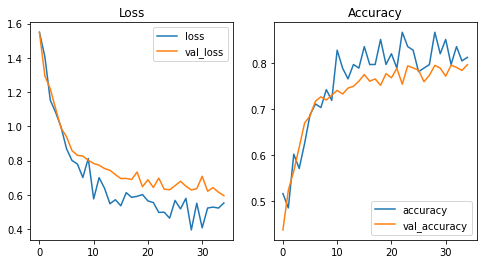

In [15]:
loss = history[MyModel.HISTORY_TRAIN_LOSS_KEY]
acc = history[MyModel.HISTORY_TRAIN_ACC_KEY]
val_loss = history[MyModel.HISTORY_VAL_LOSS_KEY]
val_acc = history[MyModel.HISTORY_VAL_ACC_KEY]

epochs = list(range(num_epochs))
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(['accuracy', 'val_accuracy'])

### 학습 결과 평가

테스트 데이터 셋에 대해서 정확도를 계산한다.

In [33]:
test_acc = model.calc_accuracy(X_test, y_test)
print(f'Test Data Accuracy: {test_acc}')

Test Data Accuracy: 0.7778


테스트 데이터 셋에 대해서 약 **78%** 의 정확도를 달성한 것을 확인할 수 있다.

### 학습 결과 저장

학습된 현재 모델의 weights를 `trained_weights`에 저장한다.

In [31]:
checkpoint = tf.train.Checkpoint(model)
saved_path = checkpoint.write('./trained_weights')

### 학습 결과 로드

위에서 저장한 학습 결과를 읽어서 테스트 데이터 셋에 대해서 정확도를 계산해본다.

In [36]:
model2 = MyModel(input_shape=(img_rows, img_cols, img_ch), num_classes=num_classes)
checkpoint = tf.train.Checkpoint(model2)
checkpoint.read(saved_path).assert_existing_objects_matched()

test_acc = model2.calc_accuracy(X_test, y_test)
print(f'Test Data Accuracy: {test_acc}')

Test Data Accuracy: 0.7778


기존에 학습한 모델과 동일한 정확도가 나오는 것을 알 수 있다.